# Analyze pendulum data
Use this notebook to quickly test whether your pendulum data makes sense!

In [250]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
from scipy.stats import binom, poisson, norm


In [251]:
blinded = True            # Add a random (but fixed) offset to the 30cm and 2m data seperately

r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

In [252]:
if blinded:
    blinding = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding = 0

In [253]:
# Example file location
#Laurits = 'pendulum-timing/Laurits.dat'
#Martin = 'pendulum-timing/Martin.dat'
#Sofie = 'pendulum-timing/Sofie.dat'
Nikolaj_a ='pendulum-timing/Timer.dat'
#Nikolaj_b='Pendulum-timing/Timer2.dat'


## Data reader

In [254]:
# Read in data
def read_data(filename):
    dat = np.genfromtxt(filename, delimiter='\t', names=('n', 't_s'))
    return dat

## Read and plot the data

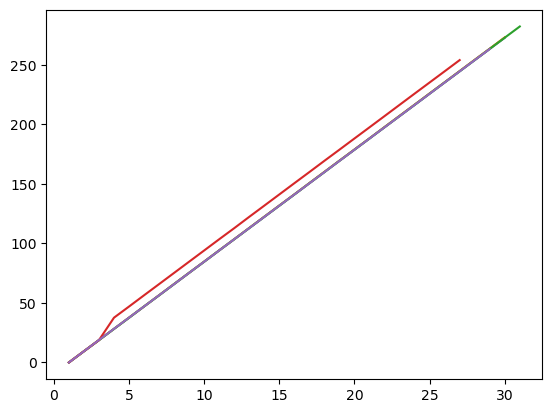

In [255]:
filenames=['pendulum-timing/Laurits.dat', 'pendulum-timing/Martin.dat', 'pendulum-timing/Sofie.dat', 'pendulum-timing/Timer.dat', 'Pendulum-timing/Timer2.dat' ]
fig, ax = plt.subplots()
n_all = np.array([])
t_all = np.array([])
for name in filenames:
    data = read_data(name)
    n = data['n']
    t = data['t_s']-data['t_s'][0]
    ax.plot(n,t)


In [256]:
# Correct the missed period in 'Timer' file Nikolaj_a: Read Nikolaj's file into a structured array and extract fields
Nikolaj_data = read_data(Nikolaj_a)
n = Nikolaj_data['n'].astype(int).copy()
t = Nikolaj_data['t_s'] - Nikolaj_data['t_s'][0]

diff = np.diff(t)

# Find gaps larger than 10 s between consecutive measurements and increment subsequent n
gap_idx = np.where(diff > 10)[0]
if gap_idx.size > 0:
	for i in gap_idx:
		n[i+1:] += 1
	print(f"Applied {gap_idx.size} gap correction(s): incremented n after indices {gap_idx.tolist()}")
else:
	print("No large gaps (>10 s) found in Nikolaj's data")

# Create a cleaned structured array for downstream use
Nikolaj_a_cleaned = np.rec.fromarrays([n, t], names=('n', 't_s'))
Nikolaj_a_cleaned

Applied 1 gap correction(s): incremented n after indices [2]


rec.array([( 1,   0.    ), ( 2,   9.4116), ( 3,  18.7687), ( 5,  37.6326),
           ( 6,  46.9901), ( 7,  56.4415), ( 8,  65.8377), ( 9,  75.2549),
           (10,  84.6814), (11,  94.0926), (12, 103.5249), (13, 112.8305),
           (14, 122.3632), (15, 131.7482), (16, 141.1706), (17, 150.5992),
           (18, 159.969 ), (19, 169.4239), (20, 178.7709), (21, 188.1859),
           (22, 197.5639), (23, 206.9794), (24, 216.4251), (25, 225.8544),
           (26, 235.2365), (27, 244.6211), (28, 254.0459)],
          dtype=[('n', '<i8'), ('t_s', '<f8')])

Total combined points: 147
Lengths: n_all=147, t_all=147, dt_all=142, n_dt_all=142
Max raw dt: 9.538, Max adjusted dt: 9.459
Number of large gaps (>10 s): 0


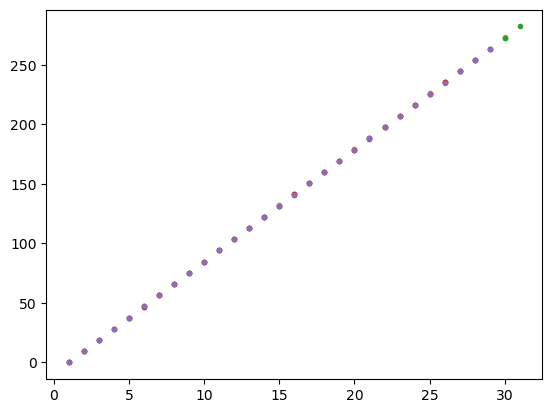

In [257]:
# Build combined arrays (use cleaned Nikolaj data for Timer.dat)
filenames = ['pendulum-timing/Laurits.dat', 'pendulum-timing/Martin.dat',
             'pendulum-timing/Sofie.dat', 'pendulum-timing/Timer.dat',
             'Pendulum-timing/Timer2.dat']
fig, ax = plt.subplots()

# Use float dtype to allow concatenation with empty arrays
n_all = np.array([], dtype=float)
t_all = np.array([], dtype=float)
dt_all = np.array([], dtype=float)
# n values aligned to dt (one per dt): for each file use n[1:]
n_dt_all = np.array([], dtype=float)

for name in filenames:
    if name.lower().endswith('timer.dat'):
        # use the cleaned Nikolaj data
        n = Nikolaj_a_cleaned['n']
        t = Nikolaj_a_cleaned['t_s']
    else:
        data = read_data(name)
        n = data['n']
        t = data['t_s']-data['t_s'][0]

    dt = np.diff(t)
    dt_adj = np.where(dt> 10, dt/ 2.0, dt)
    n_for_dt=n[1:]
    
    # Concatenate to the combined arrays
    n_all = np.concatenate((n_all, n))
    t_all = np.concatenate((t_all, t))
    dt_all = np.concatenate((dt_all, dt_adj))
    n_dt_all = np.concatenate((n_dt_all, n_for_dt))

    ax.plot(n, t, '.')


# Diagnostics
print(f'Total combined points: {len(n_all)}')
print(f'Lengths: n_all={len(n_all)}, t_all={len(t_all)}, dt_all={len(dt_all)}, n_dt_all={len(n_dt_all)}')
print(f'Max raw dt: {np.max(dt_all):.3f}, Max adjusted dt: {np.max(dt_adj):.3f}')
print(f'Number of large gaps (>10 s): {(dt_all > 10).sum()}')


Mean for all datapoints 9.4101911971831
Sigma for all datapoints 0.04650093528489065


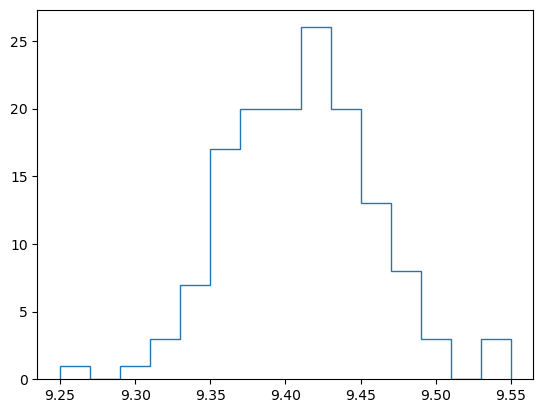

In [258]:
#investigate and find one sigma all for all datapoints
N_bins=15
xmin=9.25
xmax=9.55
fig, ax=plt.subplots()
ax.hist(dt_all, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )

mu_all=np.mean(dt_all)
#sigma_all=np.std(dt_all)
sigma_all=np.sqrt(1/(len(n_dt_all)) * np.sum((dt_all-mu_all)**2))
print(f'Mean for all datapoints {mu_all}')
print(f'Sigma for all datapoints {sigma_all}')


#print(residuals)
#print(len(residuals))
#np.max(dt_all)

#chi2 test to find sigma
#def func_gaussian(x, N, mu, sigma) :
 #   return N*norm.pdf(x, mu, sigma)

#sy=np.srt(n_dt_all) #poisson approach probably not right
#chi2_gaussian = cost.LeastSquares(x, y, sy, func_gaussian)
#fit_gaussian = Minuit(chi2_gaussian, N=N_experiments, mu=Lambda, sigma=np.sqrt(Lambda)) #   
#mfit_gaussian.migrad();         # Perform the actual fit
#Chi2_gau = mfit_gaussian.fval
#Ndof_gau = len(x) - 3           # 3 parameters in fit
#Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)
#print(Ndof_gau)


In [259]:
#linear fit to find values 
#need fit values to find uncertainty from the gaussian distribution from distance between points and fit line

# x and y are 1D numpy arrays
m, b = np.polyfit(n_all, t_all, 1)

print("slope =", m)
print("intercept =", b)

# predicted values
y_fit = m * x + b

slope = 9.411495886617889
intercept = -9.416464567457764


In [260]:
#residuals

residuals_a=mu_all-dt_all #residuals finder I dem sådan her?

residuals_b=m-dt_all #or like this, difference from slope and each point



Sigma for all datapoints 0.04650093528489065


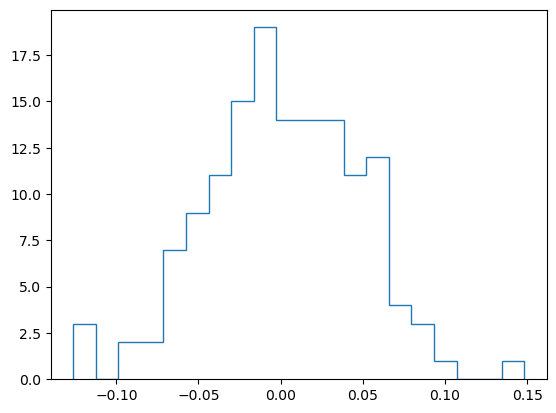

In [261]:
#uncertainty found as the width from the gaussian distribution of the distances from points to fit line

N_bins=20
xmin=np.min(residuals_b)
xmax=np.max(residuals_b)
fig, ax=plt.subplots()
ax.hist(residuals_b, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )

sig_T=np.std(residuals_b)

print(f'Sigma for all datapoints {sig_T}')

<ErrorbarContainer object of 3 artists>

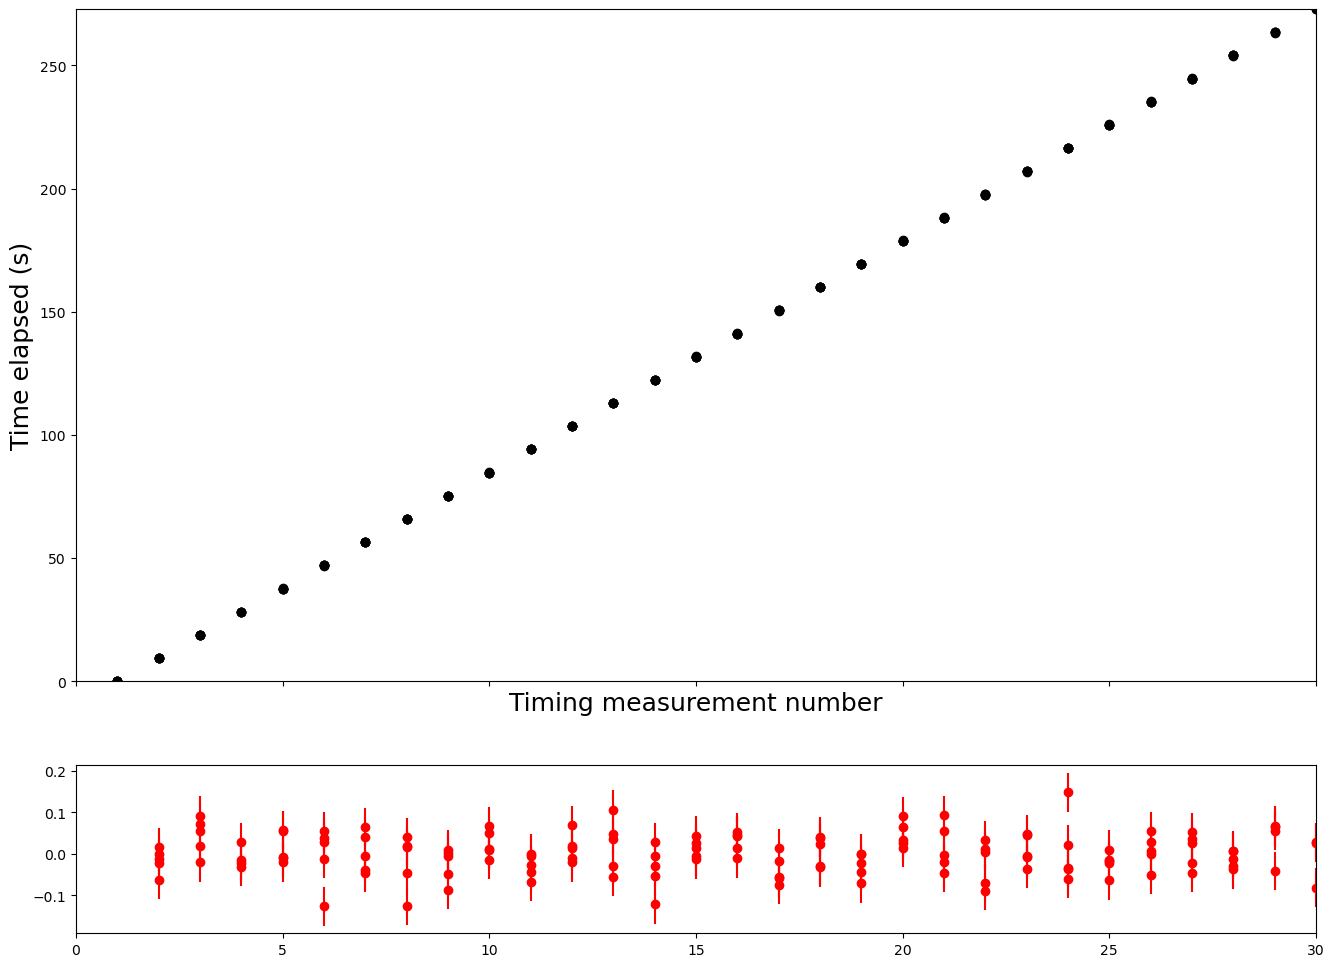

In [262]:
# Plotting
sig_t = sig_res     # Set your own values...
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), gridspec_kw={'height_ratios':[4,1]}, sharex=True)
ax[0].errorbar(n_all, t_all, yerr=sig_t, color='k', fmt='o')
ax[0].set_xlabel('Timing measurement number', fontsize=18)
ax[0].set_ylabel('Time elapsed (s)', fontsize=18)
ax[0].set(xlim=(0, n[-1]+np.ediff1d(n)[0]), ylim=(0, t[-1]+np.ediff1d(t)[0]))

ax[1].errorbar(n_dt_all, residuals_b, yerr=sig_t, color='r', fmt='o')

In [ ]:
#Chisquare fit

#define fitting function

def fit_function (x, T, b):
    return T*x+b

#Chisquare fit
N_experiments=len(n_all)
x=n_all
y=t_all
sy=sig_T

Minuit.print_level = 1      # This sets the level of printing when fitting with Minuit

fit=cost.LeastSquares(x,y,sy, fit_function)
mfit=Minuit(fit, T=9.4, b=-9.4) #performing fit and guessing the values?
mfit.migrad()
print(mfit.migrad())

Chi2 = mfit.fval
Ndof = len(x) - 2           # 2 parameters in fit
Prob = stats.chi2.sf(Chi2, Ndof)
print(Prob)

print(f'P-value for the chi-2 fit with the linear regression {Prob}. We cannot reject the hypothesis of a linear fit with T=9.41 is good')
# First, check if the result was a valid minimum:
if (not mfit.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")  

# Short hand way of accessing the fit parameters:
#fit_T, fit_b = mfit.values[1:] 
#print(fit_T)

# Loop to get both parameter values and uncertainties:
for name in mfit.parameters :
    value, error = mfit.values[name], mfit.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

T=9.4115 #manual right now

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 393.4 (χ²/ndof = 2.7)      │              Nfcn = 46               │
│ EDM = 1.51e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

# What to do next?

The reason for the (empty) plot below is, that though your data (hopefully) lies on a line, you're not able to see any smaller effects. However, if you plot the __residuals__ (the difference between your measurements and a fit to them), then you will much better be able to tell, if the data looks good. Also, it is from a historgram of the residuals, that you can determine, if your errors are Gaussian (or have any obvious outliers), and from the Standard Deviation what your (typical) uncertainty is.